In [1]:
# multivariate output 1d cnn example
import tf as tf
from numpy import array
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LSTM, LeakyReLU
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
# split a multivariate sequence into samples

In [2]:
# Загружаем датафрейм
frame = pd.read_csv('Gosloto_5x36_11.10.2020.csv', header=0, sep=';')
frame

# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz'], axis=1).astype(float)
frame

,number1,2-number,3-number,4-number,5-number,6-number
0,1.0,26.0,22.0,23.0,8.0,0.0
1,11.0,21.0,18.0,3.0,9.0,0.0
2,26.0,6.0,23.0,5.0,33.0,0.0
3,27.0,4.0,10.0,11.0,29.0,0.0
4,21.0,29.0,28.0,34.0,35.0,0.0
...,...,...,...,...,...,...
20493,24.0,20.0,28.0,35.0,13.0,3.0
20494,24.0,19.0,9.0,7.0,20.0,1.0
20495,26.0,9.0,30.0,35.0,1.0,1.0
20496,27.0,26.0,10.0,32.0,20.0,3.0


In [3]:
in_seq1 = frame["number1"].to_numpy()
in_seq2 = frame["2-number"].to_numpy()
in_seq3 = frame["3-number"].to_numpy()
in_seq4 = frame["4-number"].to_numpy()
in_seq5 = frame["5-number"].to_numpy()
in_seq6 = frame["6-number"].to_numpy()

in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
# horizontally stack columns
dataset_new = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))
#dataset= np.array(range(0,54,1)).reshape(9,6)

In [4]:
validat_x = dataset_new[-401:-1]
validat_y = dataset_new[-1:]

In [5]:
# нужно вычесть 5429+validat_x[!это!:]
dataset = dataset_new[:20097]


In [6]:
n_input = 400
generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=80)

#np.delete(validat)

# for i in range(len(generator)):
# 	x_g, y_g = generator[i]
# 	print('%s => %s' % (x_g, y_g))
# generator.length

In [7]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	print(len(sequences))
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			print('!')
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
# choose a number of time steps
n_steps = 6
# convert into input/output
X, y = split_sequences(dataset, n_steps)

20097
!


In [8]:
x_val1 = array([[[36 ,37, 38, 39, 40, 41], [42, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52, 53]]])
y_val1 = array( [[54, 55, 56, 57, 58, 59]])

x_val = array([validat_x])
y_val = array( validat_y)
print (x_val)
print (y_val)
print (x_val1)
print (y_val1)

[[[10. 27. 31.  7. 11.  2.]
  [34. 11.  9. 28. 19.  3.]
  [12. 10. 24. 25. 11.  4.]
  ...
  [24. 19.  9.  7. 20.  1.]
  [26.  9. 30. 35.  1.  1.]
  [27. 26. 10. 32. 20.  3.]]]
[[32. 35. 29. 20. 28.  3.]]
[[[36 37 38 39 40 41]
  [42 43 44 45 46 47]
  [48 49 50 51 52 53]]]
[[54 55 56 57 58 59]]


In [16]:
# the dataset knows the number of features, e.g. 2
#n_features = X.shape[2]
n_features = 6
# define model
model = Sequential()
model.add(Conv1D(filters=36, kernel_size=6, activation='relu', input_shape=(400, n_features)))
#model.add(BatchNormalization())
#model.add(Conv1D(filters=64, kernel_size=45, activation='relu', input_shape=(395, 64)))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(25))
#model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(200, activation='linear'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
#model.fit(X, y, epochs=3, verbose=1)
callbacks = [
  # Остановить обучение если `val_loss` перестанет улучшаться в течение 2 эпох
  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
  # Записать логи TensorBoard в каталог `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
history = model.fit_generator(generator, epochs=150, verbose=2, validation_data=(generator))#, callbacks=callbacks)
print("Ok!")
# demonstrate prediction

Epoch 1/150


KeyboardInterrupt: 

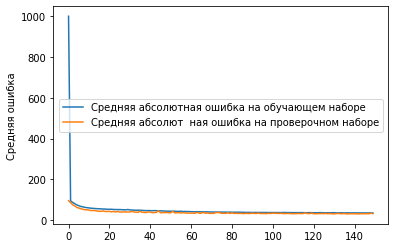

In [17]:
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолют  ная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [18]:
# x_input = array([[70,71,72,73,74,75], [76,77,78,79,80,81], [82,83,84,85,86,87]])
# x_input = x_input.reshape((1, 3, n_features))
x_input = array([dataset_new[-401:-1]])
yhat = model.predict(x_input, verbose=0)
print(yhat)
print(y_val)
print(x_input)
print (dataset_new[-401])
print (dataset_new[-1])
print(y_val-yhat)


[[13.3807335 21.745367  19.283459  17.09753   14.609258  -3.9557807]]
[[32. 35. 29. 20. 28.  3.]]
[[[10. 27. 31.  7. 11.  2.]
  [34. 11.  9. 28. 19.  3.]
  [12. 10. 24. 25. 11.  4.]
  ...
  [24. 19.  9.  7. 20.  1.]
  [26.  9. 30. 35.  1.  1.]
  [27. 26. 10. 32. 20.  3.]]]
[10. 27. 31.  7. 11.  2.]
[32. 35. 29. 20. 28.  3.]
[[18.61926651 13.25463295  9.71654129  2.90246964 13.3907423   6.95578074]]
